In [1]:
### Import packages 
import networkx as nx # for handling graphs/networks 
import numpy as np # for basic scientific computing 
import pandas as pd # for basic scientific computing 
import matplotlib.pyplot as plt # for plotting
import matplotlib.gridspec as gridspec

import seaborn as sns

from scipy.special import binom
from scipy.linalg import subspace_angles

from scipy.integrate import solve_ivp
import Koopman_source as kp
from math import comb
#from copy import copy
import csv  
from scipy.optimize import minimize
from scipy.special import expit


In [2]:
np.random.seed(123)

## Compute a Koopman matrix from simulated data.

#x0 = [2,1]

model = "Duffing"
sequential = False

if model == "d2_ans":
    d = 2
elif model == "d2":
    d = 2 # the number of variables (=the dimension) of the original dynamical system.
elif model == "d3":
    d = 3
elif model == "Lorenz":
    d = 3
elif model == "Lotka_Voltera":
    d = 2
elif model == "Duffing":
    d = 2

#M = 100 # the number of observed data. 

orth_basis = True

M_max = 2000 # the maximum number of observed data. 
n_repeat = 2 # the number of repetition of approximaing the Koopman matrix. 
max_order = 7
N = comb(d+max_order,d) # the total number of observable functions, psi_m's. 
# N1 = 4 
# N2 = N - N1

In [98]:

K_approx_accum = np.zeros([N,N,M_max,n_repeat])
G_approx_accum = np.zeros([N,N,M_max,n_repeat])
G_pinv_accum = np.zeros([N,N,M_max,n_repeat])
A_approx_accum = np.zeros([N,N,M_max,n_repeat])
P_accum = np.zeros([M_max,M_max,M_max,n_repeat])


alpha0 = -1
beta0 = 1
delta0 = 0.3 # Damping parameter
# delta0 = 0.0 # Damping parameter
dt = 0.05

for rr in range(n_repeat):
    if np.mod(rr, 2) == 0:
        print(rr)
    x_mat_total = np.random.default_rng().exponential(scale=1, size=[d,M_max])
    # x_mat_total = np.zeros([d,M_max])
    # x_mat_total[:,0] = np.array([0.1,0.1])
    y_mat_total = np.zeros([d,M_max])

    K_approx = np.zeros([N,N,M_max])
    G_approx = np.zeros([N,N,M_max])
    G_pinv = np.zeros([N,N,M_max])
    A_approx = np.zeros([N,N,M_max])

    for i in range(M_max):
        if sequential == True:
            if model == "Duffing":
                y_mat_total[:,i] = kp.Duffing(x_mat_total[:,i], alpha0=alpha0, beta0 = beta0, delta0 = delta0, dt = dt)
                if i+1 < M_max:
                    x_mat_total[:,i+1] = y_mat_total[:,i]
        else:
            if model == "Duffing":
                y_mat_total[:,i] = kp.Duffing(x_mat_total[:,i], alpha0=alpha0, beta0 = beta0, delta0 = delta0, dt = dt)

    Psi_X = np.zeros([M_max,N])
    Psi_Y = np.zeros([M_max,N])

    for i in range(M_max):
        if model == "Duffing":
            Psi_X[i,:], ind_mat = kp.psi_Laguerre(x_mat_total[:,i], d, max_order)
            Psi_Y[i,:] = kp.psi_Laguerre(y_mat_total[:,i], d, max_order)[0]

    G_approx[:,:,0] = np.matmul(Psi_X[np.ix_(range(1),range(N))].transpose(), Psi_X[np.ix_(range(1),range(N))])
    G_pinv[:,:,0] = np.linalg.pinv(G_approx[:,:,0])
    A_approx[:,:,0] = np.matmul(Psi_X[np.ix_(range(1),range(N))].transpose(), Psi_Y[np.ix_(range(1),range(N))])
    K_approx[:,:,0] = np.matmul(G_pinv[:,:,0], A_approx[:,:,0])

    for M in range(2,M_max+1):  
        G_approx[:,:,M-1] = G_approx[:,:,M-2] + np.matmul(Psi_X[np.ix_(range(M-1,M),range(N))].transpose(), Psi_X[np.ix_(range(M-1,M),range(N))])
        G_pinv[:,:,M-1] = np.linalg.pinv(G_approx[:,:,M-1])
        A_approx[:,:,M-1] = A_approx[:,:,M-2] + np.matmul(Psi_X[np.ix_(range(M-1,M),range(N))].transpose(), Psi_Y[np.ix_(range(M-1,M),range(N))])
        K_approx[:,:,M-1] = np.matmul(G_pinv[:,:,M-1], A_approx[:,:,M-1])

    G_approx_accum[:,:,:,rr] = G_approx
    G_pinv_accum[:,:,:,rr] = G_pinv
    A_approx_accum[:,:,:,rr] = A_approx
    K_approx_accum[:,:,:,rr] = K_approx

0


Text(978.81045751634, 0.5, 'Rows')

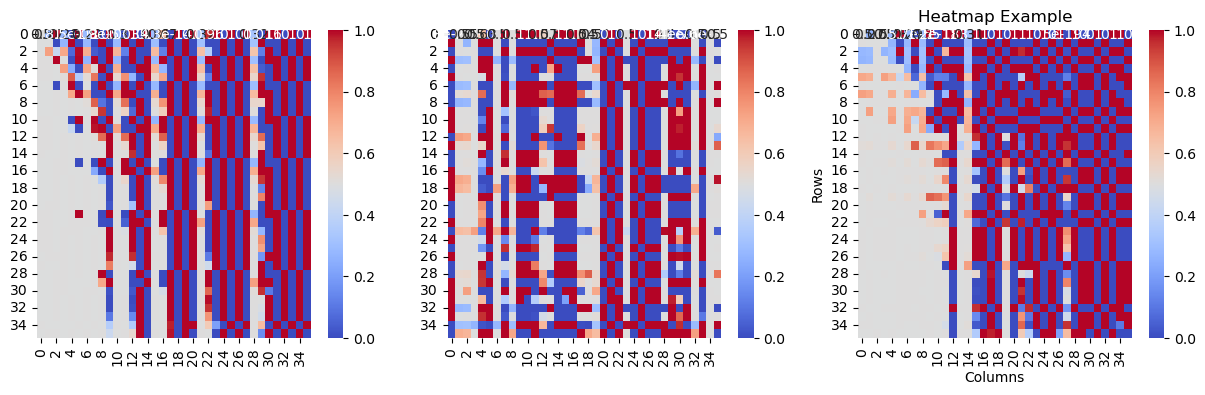

In [104]:
mixed_idx = np.random.permutation(N)

data = K_approx[:,:,M_max-1]
data = 1/dt * (np.squeeze(data) - np.identity(N))

eig_v = kp.pagerank(abs(data), 10000, 0.7)
eig_v2 = kp.subsampled_pagerank(abs(data), 10000, 0.7, 0.3)
ranked_idx = np.argsort(eig_v)[::-1]
ranked_idx2 = np.argsort(eig_v2)[::-1]

data_mx = data[np.ix_(mixed_idx,mixed_idx)]
# data_mx = 1/dt * (np.squeeze(data_mx) - np.identity(N))

data_pr = data[np.ix_(ranked_idx,ranked_idx)]
# data_pr = 1/dt * (np.squeeze(data_pr) - np.identity(N))

data_subpr = data[np.ix_(ranked_idx2,ranked_idx2)]
# data_subpr = 1/dt * (np.squeeze(data_subpr) - np.identity(N))

# Create a heatmap
#fig2, ax2 = plt.subplots(len(i_list), len(j_list), figsize = (8,8))
fig1, ax1 = plt.subplots(1,3,figsize = (15,4))
#plt.figure(figsize=(8, 6))
sns.heatmap(expit(data*1), ax=ax1[0], annot=True, cmap='coolwarm', cbar=True)
sns.heatmap(expit(data_mx*1), ax=ax1[1], annot=True, cmap='coolwarm', cbar=True)
sns.heatmap(expit(data_pr*1), ax=ax1[2], annot=True, cmap='coolwarm', cbar=True)# sns.heatmap(expit(data_subpr*10), ax=ax1[2], annot=True, cmap='coolwarm', cbar=True)
# sns.heatmap(expit(data_pr*100), annot=True, cmap='coolwarm', cbar=True)
# sns.heatmap(1/(1+np.exp(-data)), annot=True, cmap='coolwarm', cbar=True)

# Add title and labels
plt.title("Heatmap Example")
plt.xlabel("Columns")
plt.ylabel("Rows")


In [100]:
# Computing the subspace angles with increasing number of (ordered) basis functions.

subsp_ang_mx = np.zeros(N)
subsp_ang_inc = np.zeros(N)
subsp_ang_pr = np.zeros(N)
subsp_ang_subpr = np.zeros(N)

M_ang = 1000
dataX_for_angle = np.random.default_rng().exponential(scale=1, size=[d,M_ang])
dataY_for_angle = np.random.default_rng().exponential(scale=1, size=[d,M_ang])
Psi_X_ang = np.zeros([M_ang,N])
Psi_Y_ang = np.zeros([M_ang,N])

for i in range(M_ang):
    dataY_for_angle[:,i] = kp.Duffing(dataX_for_angle[:,i], alpha0=alpha0, beta0 = beta0, delta0 = delta0, dt = dt)

for i in range(M_ang):
    Psi_X_ang[i,:], ind_mat = kp.psi_Laguerre(dataX_for_angle[:,i], d, max_order)
    Psi_Y_ang[i,:] = kp.psi_Laguerre(dataY_for_angle[:,i], d, max_order)[0]
    
for N_vary in range(2,N):
    # x_mat_total = np.random.default_rng().exponential(scale=1, size=[d,M_max])
    # Psi_Y_ang = np.matmul(Psi_X_ang[np.ix_(range(M_ang),range(N_vary))], data[np.ix_(range(N_vary),range(N_vary))])
    subsp_ang_inc[N_vary] = subspace_angles(Psi_X_ang[np.ix_(range(M_ang),range(N_vary))], Psi_Y_ang[np.ix_(range(M_ang),range(N_vary))])[0]
    subsp_ang_mx[N_vary] = subspace_angles(Psi_X_ang[np.ix_(range(M_ang),mixed_idx[range(N_vary)])], Psi_Y_ang[np.ix_(range(M_ang),mixed_idx[range(N_vary)])])[0]
    subsp_ang_pr[N_vary] = subspace_angles(Psi_X_ang[np.ix_(range(M_ang),ranked_idx[range(N_vary)])], Psi_Y_ang[np.ix_(range(M_ang),ranked_idx[range(N_vary)])])[0]
    subsp_ang_subpr[N_vary] = subspace_angles(Psi_X_ang[np.ix_(range(M_ang),ranked_idx2[range(N_vary)])], Psi_Y_ang[np.ix_(range(M_ang),ranked_idx2[range(N_vary)])])[0]



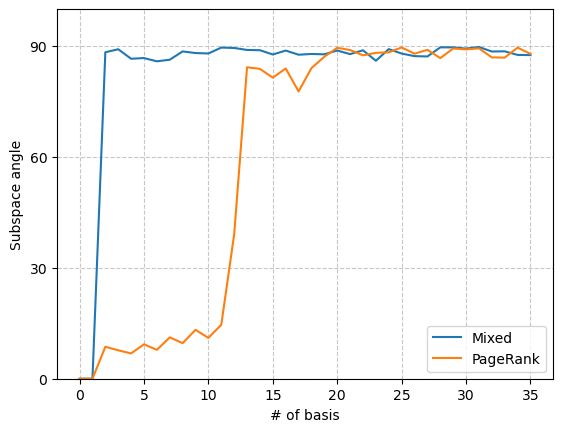

In [101]:
# plt.plot(subsp_ang_inc * 180/np.pi)
plt.plot(subsp_ang_mx * 180/np.pi)
plt.ylim([0, 100])
plt.yticks([0, 30, 60, 90])
plt.xlabel("# of basis")
plt.ylabel("Subspace angle")
plt.plot(subsp_ang_pr * 180/np.pi)
# plt.plot(subsp_ang_subpr * 180/np.pi)
# plt.xlabel("Basis functions")
# plt.ylabel("PageRank")
plt.legend(["Mixed", "PageRank", "Sub-PageRank"])
plt.grid(True, linestyle='--', alpha=0.7)


In [51]:
data

array([[-6.51715996e-02, -9.91649331e-01,  5.59628371e+00,
        -9.40111533e-01, -1.63980567e+01,  1.12685428e+01,
        -1.01072673e+00,  2.00807214e+01, -2.91055856e+01,
         2.64623839e+01, -8.87332279e-01, -7.78977060e+00,
         8.03426708e+00, -5.36953631e+01,  4.28890515e+01,
        -9.44495112e-01, -1.38693362e+02, -1.08850010e+02,
        -7.08508420e+01, -1.25015855e+02,  6.05252519e+01,
        -8.78171351e-01, -3.65552316e+02, -4.46995185e+02,
        -3.56139186e+02, -2.82507618e+02, -3.08001890e+02,
         5.81762189e+01],
       [-1.47800320e-03, -5.79274136e-03, -1.69898906e+01,
        -9.98471600e-01,  7.55256802e+01, -5.84706764e+01,
        -9.62285807e-01, -1.24237551e+02,  1.48514560e+02,
        -1.36773608e+02, -9.50958816e-01,  9.32202778e+01,
        -5.45478982e+01,  2.99549814e+02, -2.46199257e+02,
        -8.89632680e-01,  9.35911116e+02,  7.03765759e+02,
         3.99351295e+02,  6.25319511e+02, -3.39920909e+02,
        -1.04253699e+00,  2.33

In [52]:
for i in ranked_idx:
    print(ind_mat[i])

[2, 0]
[3, 0]
[1, 0]
[0, 0]
[0, 1]
[4, 0]
[0, 3]
[0, 2]
[0, 4]
[1, 1]
[2, 1]
[5, 0]
[3, 1]
[0, 5]
[4, 1]
[1, 2]
[1, 3]
[6, 0]
[2, 2]
[0, 6]
[1, 4]
[3, 2]
[5, 1]
[2, 3]
[1, 5]
[4, 2]
[3, 3]
[2, 4]


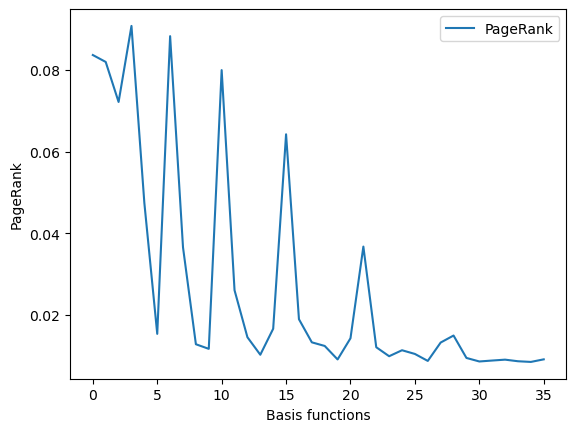

In [102]:
plt.plot(eig_v)
plt.xlabel("Basis functions")
plt.ylabel("PageRank")
# plt.plot(eig_v2)
# plt.xlabel("Basis functions")
# plt.ylabel("PageRank")
plt.legend(["PageRank", "Subsampled PageRank"])

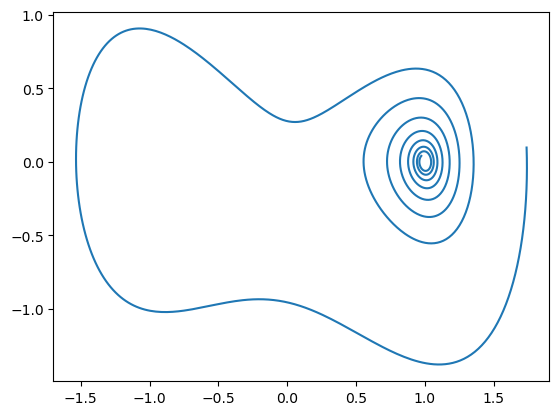

In [54]:
x_mat_total.shape
plt.plot(x_mat_total[0,:], x_mat_total[1,:])

In [21]:
x_mat_total

array([[0.59000614, 1.57768456, 0.94366986, ..., 0.22319389, 3.16766237,
        0.58101729],
       [3.23856989, 0.53289797, 0.24933135, ..., 1.84417314, 0.46472142,
        0.29815608]])